# Forecasting using spatio-temporal data with combined Graph Convolution + LSTM model

In [2]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [3]:
# import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))

In [4]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [5]:
import os
import sys
import urllib.request
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

## Loading and preprocessing the data

In [6]:
import stellargraph as sg

This demo is based on the preprocessed version of the dataset used by the TGCN paper.

In [7]:
dataset = sg.datasets.METR_LA()

C:\Users\Randhir Kumar\AppData\Local\Temp\ipykernel_23020\379535381.py:1: ExperimentalWarning: METR_LA is experimental: tests and documentation missing (see: https://github.com/stellargraph/stellargraph/issues/1303). It may be difficult to use and may have major changes at any time.
  dataset = sg.datasets.METR_LA()


In [8]:
speed_data, sensor_dist_adj = dataset.load()
num_nodes, time_len = speed_data.shape
print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)

No. of sensors: 207 
No of timesteps: 2016


In [9]:
print(sensor_dist_adj)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.71743792 ... 0.         0.         0.        ]
 [0.         0.71743792 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


**Let's look at a sample of speed data.**

In [10]:
speed_data.head()
speed_data.shape

(207, 2016)

In [11]:
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

In [12]:
train_rate = 0.8

In [13]:
train_data, test_data = train_test_split(speed_data, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (207, 1612)
Test data:  (207, 404)


In [14]:
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [15]:
train_scaled, test_scaled = scale_data(train_data, test_data)

In [16]:
seq_len = 20
pre_len = 22

In [17]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [18]:
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1571, 207, 20)
(1571, 207)
(363, 207, 20)
(363, 207)


## StellarGraph Graph Convolution and LSTM model

In [19]:
from stellargraph.layer import GCN_LSTM

In [20]:
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=sensor_dist_adj,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)

C:\Users\Randhir Kumar\AppData\Local\Temp\ipykernel_23020\324283869.py:1: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  gcn_lstm = GCN_LSTM(


In [21]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [22]:
model = Model(inputs=x_input, outputs=x_output)

In [23]:
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [24]:
tf.config.list_physical_devices('GPU')

[]

In [24]:
history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=1,
    validation_data=[testX, testY],
)

Epoch 1/100
27/27 [==============================] - 9s 107ms/step - loss: 0.1883 - mse: 0.0650 - val_loss: 0.1253 - val_mse: 0.0479
Epoch 2/100
27/27 [==============================] - 2s 56ms/step - loss: 0.1065 - mse: 0.0338 - val_loss: 0.1104 - val_mse: 0.0429
Epoch 3/100
27/27 [==============================] - 1s 52ms/step - loss: 0.1009 - mse: 0.0315 - val_loss: 0.1068 - val_mse: 0.0415
Epoch 4/100
27/27 [==============================] - 1s 52ms/step - loss: 0.0958 - mse: 0.0297 - val_loss: 0.1061 - val_mse: 0.0411
Epoch 5/100
27/27 [==============================] - 1s 52ms/step - loss: 0.0926 - mse: 0.0287 - val_loss: 0.1032 - val_mse: 0.0396
Epoch 6/100
27/27 [==============================] - 1s 52ms/step - loss: 0.0908 - mse: 0.0286 - val_loss: 0.1030 - val_mse: 0.0395
Epoch 7/100
27/27 [==============================] - 2s 62ms/step - loss: 0.0894 - mse: 0.0281 - val_loss: 0.1035 - val_mse: 0.0400
Epoch 8/100
27/27 [==============================] - 1s 54ms/step - loss: 0

27/27 [==============================] - 2s 63ms/step - loss: 0.0589 - mse: 0.0124 - val_loss: 0.0662 - val_mse: 0.0154
Epoch 63/100
27/27 [==============================] - 2s 63ms/step - loss: 0.0593 - mse: 0.0127 - val_loss: 0.0675 - val_mse: 0.0165
Epoch 64/100
27/27 [==============================] - 2s 68ms/step - loss: 0.0583 - mse: 0.0124 - val_loss: 0.0664 - val_mse: 0.0158
Epoch 65/100
27/27 [==============================] - 2s 71ms/step - loss: 0.0578 - mse: 0.0121 - val_loss: 0.0683 - val_mse: 0.0172
Epoch 66/100
27/27 [==============================] - 2s 65ms/step - loss: 0.0576 - mse: 0.0121 - val_loss: 0.0690 - val_mse: 0.0162
Epoch 67/100
27/27 [==============================] - 2s 64ms/step - loss: 0.0581 - mse: 0.0122 - val_loss: 0.0675 - val_mse: 0.0168
Epoch 68/100
27/27 [==============================] - 2s 66ms/step - loss: 0.0577 - mse: 0.0120 - val_loss: 0.0690 - val_mse: 0.0174
Epoch 69/100
27/27 [==============================] - 2s 60ms/step - loss: 0.0573 

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 207, 20)]         0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 207, 20, 1)       0         
                                                                 
 reshape (Reshape)           (None, 207, 20)           0         
                                                                 
 fixed_adjacency_graph_convo  (None, 207, 16)          43376     
 lution (FixedAdjacencyGraph                                     
 Convolution)                                                    
                                                                 
 fixed_adjacency_graph_convo  (None, 207, 10)          43216     
 lution_1 (FixedAdjacencyGra                                     
 phConvolution)                                              

In [26]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.05231809616088867 
Test loss: 0.06458969414234161


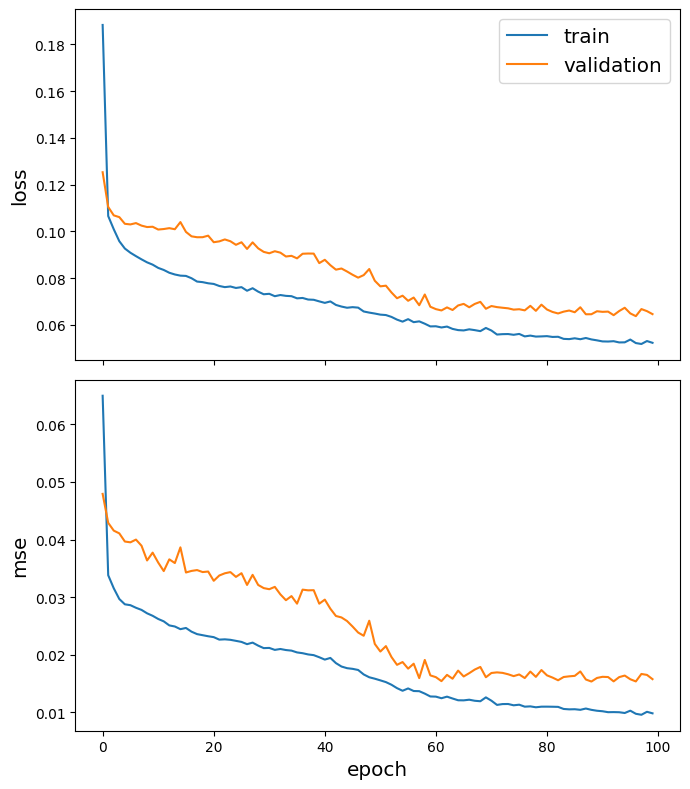

In [27]:
sg.utils.plot_history(history)

In [28]:
ythat = model.predict(trainX)
yhat = model.predict(testX)

12/12 [==============================] - 0s 20ms/step


## Rescale values

Rescale the predicted values to the original value range of the timeseries.

In [29]:
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)

In [30]:
## Rescale model predicted values
train_rescpred = np.array((ythat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)

## Measuring the performance of the model

To understand how well the model is performing, we compare it against a naive benchmark.

1. Naive prediction: using the most recently **observed** value as the predicted value. Note, that albeit being **naive** this is a very strong baseline to beat. Especially, when speeds are recorded at a 5 minutes granularity,  one does not expect many drastic changes within such a short period of time. Hence, for short-term predictions naive is a reasonable good guess.

### Naive prediction benchmark (using latest observed value)

In [31]:
## Naive prediction benchmark (using previous observed value)

testnpred = np.array(testX)[
    :, :, -1
]  # picking the last speed of the 10 sequence for each segment in each sample
testnpredc = (testnpred) * max_speed

In [32]:
## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(testX.shape[-1]):

    seg_mael.append(
        np.mean(np.abs(test_rescref.T[j] - test_rescpred.T[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref.T[j] - testnpredc.T[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction."
)

Total (ave) MAE for NN: 4.070758616167252
Total (ave) MAE for naive prediction: 7.418177552933645
Total (ave) MASE for per-segment NN/naive MAE: 0.5594641694362127
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


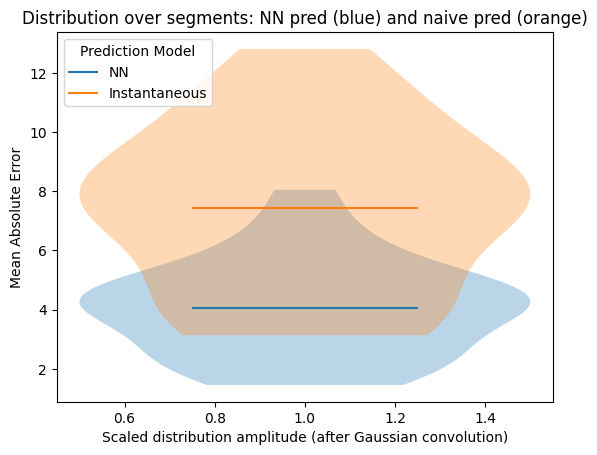

In [33]:
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
# xl = minsl

ax.violinplot(
    list(seg_mael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

ax.violinplot(
    list(seg_nmael), showmeans=True, showmedians=False, showextrema=False, widths=1.0
)

line1 = mlines.Line2D([], [], label="NN")
line2 = mlines.Line2D([], [], color="C1", label="Instantaneous")

ax.set_xlabel("Scaled distribution amplitude (after Gaussian convolution)")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Distribution over segments: NN pred (blue) and naive pred (orange)")
plt.legend(handles=(line1, line2), title="Prediction Model", loc=2)
plt.show()

#### Plot of actual and predicted speeds on a sample sensor

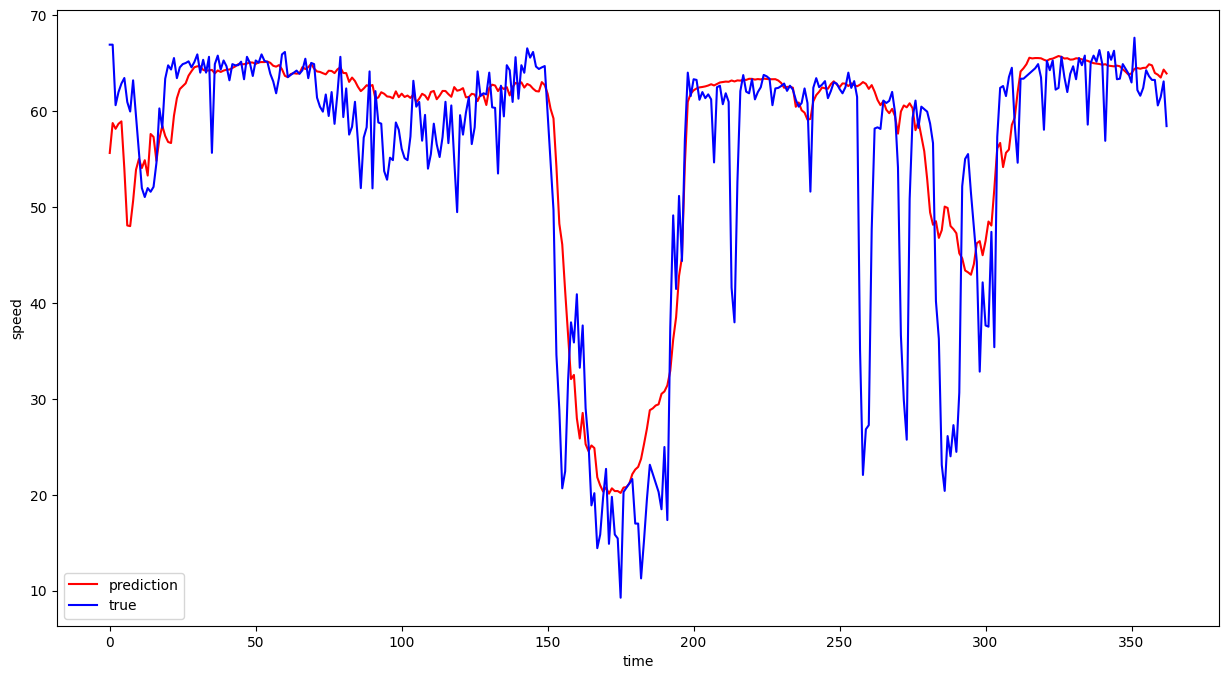

In [34]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 100]
a_true = test_rescref[:, 100]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()